# **Introduction**

This is the second part of our journey to predict the rating for a given reviews. After an explanatory analysis, we will in this notebook extract the tfidf matrix from our corpus, then apply multi-classes classification algorithm to the extracted matrix.

# **Importing Packages**

In [6]:
import os  # Get directory
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  # Pretty plots :)
from sklearn.model_selection import train_test_split

# Set the theme
sns.set_theme()

# Print every output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Retrieve current directory
repo = os.getcwd()

In [7]:
# Load data
x_train = pd.read_csv(repo+'/train.csv')
y_train = pd.read_csv(repo+'/train_labels.csv')

x_val = pd.read_csv(repo+'/valid.csv')
y_val = pd.read_csv(repo+'/valid_labels.csv')  

x_test = pd.read_csv(repo+'/test.csv')
y_test = pd.read_csv(repo+'/test_labels.csv')  


# Check data types
x_train.head(3)
print('\n Shape of train data', x_train.shape)
print('\n Shape of validation data', x_val.shape)
print('\n Shape of test data', x_test.shape)

,Summary,Text,Summary_prep,Text_prep
0,"Not Impressive, but it is what it is",I agree that the shipping is too high. A litt...,impressive,agree ship high little fishy taste prefer larg...
1,Itchy scratchy golden retriever no more,This food is the best. Our golden retriever w...,itchy scratchy golden retriever,food best golden retriever prone sort allergie...
2,Perfect Every Cup,Since I must have my morning cappuccino it is ...,perfect every cup,since must morning cappuccino important coffee...



 Shape of train data (36498, 4)

 Shape of validation data (9125, 4)

 Shape of test data (11406, 4)


# Sentiment classification using Bag of words models

A classical approach to this problem is to us BOW models. In the bag of words model, we will treat each input (document) as a bag of words, meaning that we extract the vocabulary of the document (unique words present in the document) as well will the frequency of the words. Next, corpus (all documents together) can be represented by a matrix where each line refers to a document and each column refers to a word in the vocabulary. At the row/column intersection, we records either the presence (binary representation) or the frequency (frequency representation) of the word in the document.

The frequency matrix is used more often since it captures the total distribution of words inside a corpus. However, there are 2 problems to this representation of the corpus :

    1. The most frequent words are "common words" (such as: I, am, they, we, are,...) => We will need to "inverse" the frequence of appearance of words in such a way that gives more weight to least common words.
    
    2. The matrix will be huge (for example our corpus has a vocabulary around 1 million words (before preprocessing)). This means that the frequency matrix will be of dimension $\approx$ 300 thousands $\prod$ 1 million.
    
That's why we decided to preprocess the textes (normalizing, removing stop words, removing punctuation, and lemmatizing words) and we will only keep the k most relevant words in the corpus. We will train everything first with the Text_prep feature



In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [9]:
def ngram_vectorizer(x_train, y_train, x_test, y_test, ngram_range=(1, 1), feature='Text', top_k=1000):
    
    """ Function returns tfidf matrix with top k most relevant words
    
    ngram_range : (1, 1) for unigram, (2, 2) for bigram and (3, 3) for trigram
    
    """

    kwargs = {
        'ngram_range': ngram_range, 
        'analyzer': 'word',
        'min_df' : 2, 
        'decode_error': 'replace' }

    vectorizer = TfidfVectorizer(**kwargs)

    # Create tfidf matrix from training text
    x_train = vectorizer.fit_transform(x_train[feature])
    x_test = vectorizer.transform(x_test[feature]).astype('float32')
    
    # Select top k of vectorized features
    selector = SelectKBest(f_classif, k=min(top_k, x_train.shape[1]))
    
    # Fit model
    selector.fit(x_train, y_train)

    # Transform data
    x_train = selector.transform(x_train).astype('float32')
    x_test = selector.transform(x_test).astype('float32')

    return(x_train, x_test)

Next, we will use the most frequently cited algorithms in text classification litterature : SVM, Naive Bayes and Passive Aggressive classification. According to the classical literrature on text classification, SVM model often gives the most 'meaningful' classification, meaning that it manages to capture the *relevant* words which are import for the classification, while Passive Aggressive classification model gives the most accurate classification. Naive Bayes model however is expected to perform the fastest.

# Training models using tfidf matrix

In [10]:
from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.naive_bayes import MultinomialNB as multiNB
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.tree import DecisionTreeClassifier as DTC

In [11]:
# Set parameters
score = 'balanced_accuracy' 
num_iteration = 100
cross_val=5

# Regularized linear models with stochastic gradient descent, feault SVM
SVC_Grid = RSCV(
    estimator = SGDC(random_state=0, class_weight='balanced'), 
    param_distributions = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 25, 50, 75, 100],},
    cv=cross_val, random_state=0,
    n_iter=num_iteration)

# ComplementNaiveBayes
NB_Grid = RSCV(
    estimator = multiNB(fit_prior=True), 
    param_distributions = {
        'alpha': [0.001, 0.01, 0.05,0.1, 0.3, 0.5, 1]}, 
    scoring = score, cv=cross_val, random_state=0,
    n_iter=num_iteration)

# Decision Tree
DT_Grid = RSCV (
    estimator = DTC(), 
    param_distributions = {
        'min_samples_split': [10, 20, 50,100],
        'max_features': ['log2']},
    scoring = score, cv=cross_val, random_state=0,
    n_iter=num_iteration)

In [12]:
from sklearn.metrics import balanced_accuracy_score
import gc

# Fit models for text data
def models_selection_grid(x_train, y_train, x_val, y_val, list_of_features, 
                          dictionary_estimators_grid, top_k_best=10000, ngram=(1, 1)):
    
    """ Function will returns a dataframe of the best classifier for each grid and for each feature chosen.
    We will apply our grids on the feature Text_prep, Summary_prep, Text_Sum_prep
    """
    list_result_final = []  # Final result list (to be transformed to df)
    
    for f in list_of_features :
        x_train, x_val = ngram_vectorizer(x_train, y_train, x_val, y_val, ngram_range=ngram, feature=f, top_k=top_k_best)
        
        for estimator in dictionary_estimators_grid.keys():
            estimator_grid = dictionary_estimators_grid[estimator]
            estimator_grid.fit(x_train, y_train)
            
            # Extract best estimator from grid search
            best_estimator = estimator_grid.best_estimator_
            best_estimator.fit(x_train, y_train)  
            y_pred_train = best_estimator.predict(x_train)
            
            # Create accuracy score for train data set
            accuracy_score_train = balanced_accuracy_score(y_train, y_pred_train) # Change here
    
            # Transform X_val
            y_pred_val = best_estimator.predict(x_val) # Change here
            
            # Create accuracy score for test data set
            accuracy_score_eval = balanced_accuracy_score(y_val, y_pred_val) # Change here
            
            # list of result for the current features/ estimator
            list_result_final.append([f, top_k_best, estimator, estimator_grid.best_score_, 
                                      estimator_grid.best_params_, accuracy_score_train, accuracy_score_eval])
    # Create the resulting DataFrame  
    result_df = pd.DataFrame(list_result_final, 
                             columns = ['Text_feature', 'Number of k best', 
                                        'Estimator chosen', 'Best_score_grid',
                                        'Best_params_grid', 'Accuracy_TrainSet_best_param', 
                                        'Accuracy_ValSet_best_param'])   
    
    result_df.sort_values(by=['Accuracy_ValSet_best_param'], ascending=False, inplace=True)
    gc.collect()
    return(result_df) 

In [13]:
import warnings
warnings.filterwarnings('ignore')  # Remove some warnings in output

In [16]:
def train_models(dict_estimators_grid, ngram:list, min_words=1000, max_words=50001, step=2000, 
                 features_to_train=['Text_prep'], plot_models=True):
    """ Function to apply the grid search for unigram, bigram trigram models"""
    
    # Create result dataframe
    classifier = list(dict_estimators_grid.keys())[0]
    
    print('='*80)
    print(f'Training for {classifier} started...')
    for ng in ngram:
        result = pd.DataFrame()
        for kbest in np.arange(min_words, max_words, step):     

            res = models_selection_grid(x_train, y_train, x_val, y_val, list_of_features=features_to_train, 
                                        dictionary_estimators_grid=dict_estimators_grid, top_k_best=kbest, ngram=ng)
            result = result.append(res)
    
        # Clean up result dataframes
        result.reset_index(inplace=True, drop=True)
    
        # Plot models 
        if plot_models:
            plt.figure(figsize=(5, 5))
            sns.lineplot(x='Number of k best', y='Accuracy_ValSet_best_param', data=result, ci=None)
            sns.scatterplot(x='Number of k best', y='Accuracy_ValSet_best_param', data=result)
            plt.title('Accuracy for ngram='+str(ng)+' model trained with'+classifier)
            plt.show()
        result = result [result['Accuracy_ValSet_best_param']==result['Accuracy_ValSet_best_param'].max()]
        print(result)    
    print('Done...')
    print('_'*80)
        

Training for Decision Tree Classification started...
Number of kbest= 1000
Number of kbest= 3000
Number of kbest= 5000
Number of kbest= 7000
Number of kbest= 9000
Number of kbest= 11000
Number of kbest= 13000
Number of kbest= 15000
Number of kbest= 17000
Number of kbest= 19000
Number of kbest= 21000
Number of kbest= 23000
Number of kbest= 25000
Number of kbest= 27000
Number of kbest= 29000


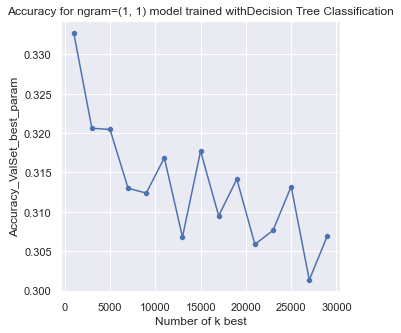

  Text_feature  Number of k best              Estimator chosen  \
0    Text_prep              1000  Decision Tree Classification   

   Best_score_grid                                   Best_params_grid  \
0         0.330168  {'min_samples_split': 10, 'max_features': 'log2'}   

   Accuracy_TrainSet_best_param  Accuracy_ValSet_best_param  
0                      0.769717                    0.332741  
Number of kbest= 1000
Number of kbest= 3000
Number of kbest= 5000
Number of kbest= 7000
Number of kbest= 9000
Number of kbest= 11000
Number of kbest= 13000
Number of kbest= 15000
Number of kbest= 17000
Number of kbest= 19000
Number of kbest= 21000
Number of kbest= 23000
Number of kbest= 25000
Number of kbest= 27000
Number of kbest= 29000


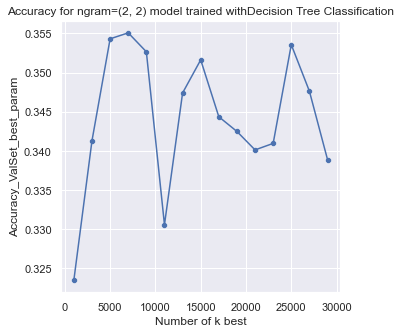

  Text_feature  Number of k best              Estimator chosen  \
3    Text_prep              7000  Decision Tree Classification   

   Best_score_grid                                   Best_params_grid  \
3         0.366628  {'min_samples_split': 20, 'max_features': 'log2'}   

   Accuracy_TrainSet_best_param  Accuracy_ValSet_best_param  
3                      0.696079                    0.355073  
Number of kbest= 1000
Number of kbest= 3000
Number of kbest= 5000
Number of kbest= 7000
Number of kbest= 9000
Number of kbest= 11000
Number of kbest= 13000
Number of kbest= 15000
Number of kbest= 17000
Number of kbest= 19000
Number of kbest= 21000
Number of kbest= 23000
Number of kbest= 25000
Number of kbest= 27000
Number of kbest= 29000


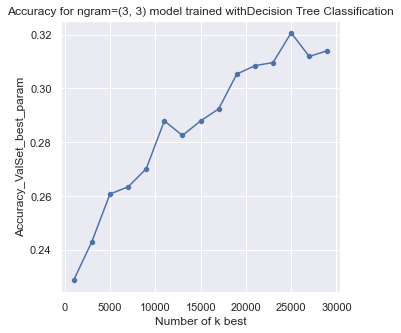

   Text_feature  Number of k best              Estimator chosen  \
12    Text_prep             25000  Decision Tree Classification   

    Best_score_grid                                   Best_params_grid  \
12         0.375336  {'min_samples_split': 20, 'max_features': 'log2'}   

    Accuracy_TrainSet_best_param  Accuracy_ValSet_best_param  
12                      0.628143                    0.320623  
Done...
________________________________________________________________________________
Training for Naive Bayes Multi-label Classifier started...
Number of kbest= 1000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 3000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 5000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 7000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 9000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 11000
Fitting 5

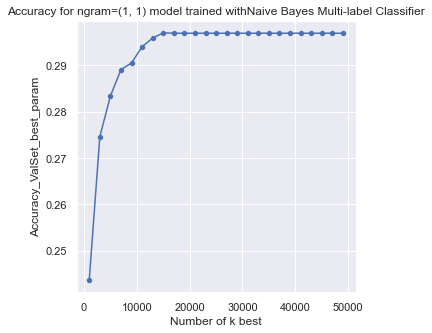

  Text_feature  Number of k best                    Estimator chosen  \
7    Text_prep             15000  Naive Bayes Multi-label Classifier   

   Best_score_grid Best_params_grid  Accuracy_TrainSet_best_param  \
7         0.300667  {'alpha': 0.01}                       0.45903   

   Accuracy_ValSet_best_param  
7                    0.297047  
Number of kbest= 1000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 3000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 5000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 7000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 9000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 11000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 13000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 15000
Fitting 5 folds for each of 7 candidates, totalling 3

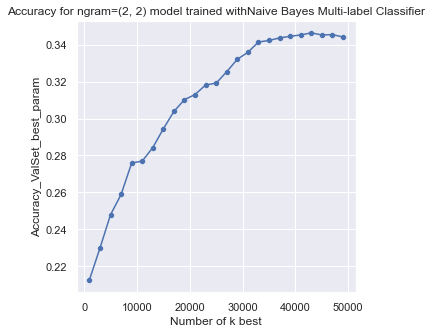

   Text_feature  Number of k best                    Estimator chosen  \
21    Text_prep             43000  Naive Bayes Multi-label Classifier   

    Best_score_grid  Best_params_grid  Accuracy_TrainSet_best_param  \
21         0.459866  {'alpha': 0.001}                      0.872247   

    Accuracy_ValSet_best_param  
21                    0.346396  
Number of kbest= 1000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 3000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 5000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 7000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 9000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 11000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 13000
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Number of kbest= 15000
Fitting 5 folds for each of 7 candidates, tot

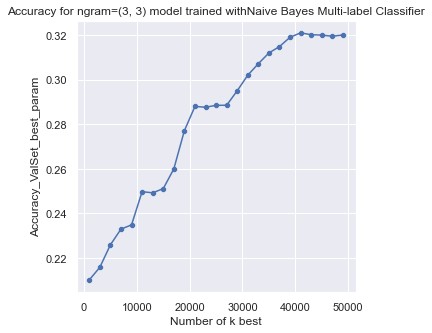

   Text_feature  Number of k best                    Estimator chosen  \
20    Text_prep             41000  Naive Bayes Multi-label Classifier   

    Best_score_grid  Best_params_grid  Accuracy_TrainSet_best_param  \
20         0.366969  {'alpha': 0.001}                      0.745615   

    Accuracy_ValSet_best_param  
20                     0.32097  
Done...
________________________________________________________________________________
Training for SVM Classification started...
Number of kbest= 1000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbest= 3000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbest= 5000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbest= 7000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbest= 9000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbest= 11000
Fitting 5 folds for each of 13 candidates, totalling 65 fits
Number of kbe

In [17]:
# Define dictionary of estimators
NB_dict = {'Naive Bayes Multi-label Classifier' : NB_Grid}
SVM_dict = {'SVM Classification' : SVC_Grid}
DT_dict = {'Decision Tree Classification' : DT_Grid}

# Train with different classifiers
train_models(DT_dict, ngram=[(1,1), (2,2), (3,3)], min_words=1000, max_words=30000)
train_models(NB_dict, ngram=[(1,1), (2,2), (3,3)])
train_models(SVM_dict, ngram=[(1,1), (2,2), (3,3)])

# Remarks on outcomes

**Remarks about Naive Bayes model** :
    - The best accuracy ($\approx$ 32%) is acheived with trigram tfidf matrix 
    - Best number of most relevant words are 49k with alpha=0.001
    
**Remarks about SVM model** :
    - Chaotique result
    - The best accuracy ($\approx$ 32%) is acheived with bigram tfidf matrix 
    - Best number of most relevant words are 22k with alpha=0.001

# Train again with the model chosen

In [108]:
from sklearn.pipeline import make_pipeline

In [119]:
# Document feature that we will train the model on
feature = 'Text_prep'  
print(f'Feature used for prediction {feature}')

# Create a pipeline to do all preprocessing, best features selection and apply
# the Naive Bayes model
vectorizer = TfidfVectorizer(analyzer='word', min_df=2, decode_error='replace', ngram_range=(2, 2))
selector = SelectKBest(f_classif, k=33000)
model = SGDC(alpha=1e-05)
pipe_model = make_pipeline(vectorizer, selector, model)

# Fit model on train
start = time.process_time()  # Check time used to fit
pipe_model.fit(train[feature], y_train)  
print('\n Time used to fit train data', time.process_time() - start, 's')
print('\n'+'_'*120)

# Define test texts
predicted_test = pipe_model.predict(test[feature])
predicted_train = pipe_model.predict(train[feature])

Feature used for prediction Text_prep


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(decode_error='replace', min_df=2,
                                 ngram_range=(2, 2))),
                ('selectkbest', SelectKBest(k=33000)),
                ('sgdclassifier', SGDClassifier(alpha=1e-05))])


 Time used to fit train data 5.515625 s

________________________________________________________________________________________________________________________


In [116]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

Detail:
              precision    recall  f1-score   support

           1       0.62      0.42      0.50      1066
           2       0.56      0.12      0.20       581
           3       0.51      0.15      0.23       827
           4       0.53      0.14      0.22      1628
           5       0.72      0.98      0.83      7304

    accuracy                           0.70     11406
   macro avg       0.59      0.36      0.40     11406
weighted avg       0.66      0.70      0.64     11406



<AxesSubplot:>

[Text(0.5, 12.5, 'Predicted'),
 Text(30.5, 0.5, 'True Class'),
 [Text(0.5, 0, '5'),
  Text(1.5, 0, '2'),
  Text(2.5, 0, '3'),
  Text(3.5, 0, '4'),
  Text(4.5, 0, '1')],
 [Text(0, 0.5, '5'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '1')],
 Text(0.5, 1.0, 'Confusion matrix for test data')]

<AxesSubplot:>

[Text(0.5, 12.5, 'Predicted'),
 Text(30.5, 0.5, 'True Class'),
 [Text(0.5, 0, '5'),
  Text(1.5, 0, '2'),
  Text(2.5, 0, '3'),
  Text(3.5, 0, '4'),
  Text(4.5, 0, '1')],
 [Text(0, 0.5, '5'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '1')],
 Text(0.5, 1.0, 'Confusion matrix for train data')]

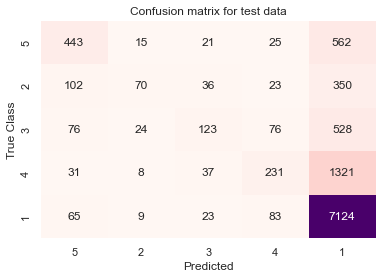

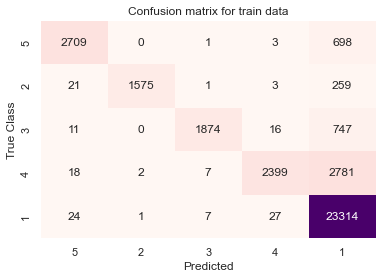

In [145]:
print("Detail:")
print(classification_report(y_test, predicted_test))
print('='*120)
    
classes = y_test.iloc[:,0].unique()
## Plot confusion matrix
cf_matrix = confusion_matrix(y_test, predicted_test)
fig, ax = plt.subplots()
sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='RdPu', 
            cbar=False, fmt='d')
ax.set(xlabel="Predicted", ylabel="True Class", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix for test data")


## Plot confusion matrix
cf_matrix = confusion_matrix(y_train, predicted_train)
fig, ax = plt.subplots()
sns.heatmap(cf_matrix, annot=True, ax=ax, cmap='RdPu', 
            cbar=False, fmt='d')
ax.set(xlabel="Predicted", ylabel="True Class", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix for train data")

For the test data set, as we expected, the classification algorithm had the best performance with the most popular class : Score=5. For the class number 2, the algorithm predicted mostly 5, while with class number 1, the algorithm predicted mostly 4.

In order to see what caused the algorithm to predict a certain score, we can use the Lime package.

# **Explain model with Lime**

Since the model learnt the texts in train data, we can try to understand what led the model to predict a certain score based on the review from train data.


In [175]:
import random
import lime  # Explainer
import lime.lime_tabular

random.seed(0)  # Fix a seed
n = random.randint(0, len(train))  # Index of observation that we want to explai

# Check what is in the text data 
train.iloc[n, 1]

# Pick Text instance
txt = train[feature][n]

## check true value and predicted value
print('='*80)
print("True Score:", y_train.iloc[n], "--> Predicted Score:", predicted_train[n], '\n')
print('='*80)
      
## show explanation


"When I first opened the bottle it smelled medicinal. I added it to some iced tea and it tasted just like it smelled, very medicinal and only a trace of fruit flaver. I ordered 2 other flavors and they're the same. I gave it an extra star because service is good, but I can't recommend the extract."

True Score: Score    2
Name: 25247, dtype: int64 --> Predicted Score: 2 



TypeError: '(slice(None, None, None), 0)' is an invalid key